In [3]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

In [5]:
test_dataset = KittiGraphDataset(basedir, "09")
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
checkpoint = torch.load("./models/model_1700665412.678221.pth")

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [7]:
SELECTED_IDX = 0

predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch)
        predicted_poses.append(output.cpu().numpy()[SELECTED_IDX])
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])

100%|██████████| 1586/1586 [00:03<00:00, 456.64it/s]


In [8]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]

    rot = R.from_quat(rot).as_euler("xyz", degrees=True)
    return {
        "position": pos,
        "rotation": rot,
    }

In [9]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

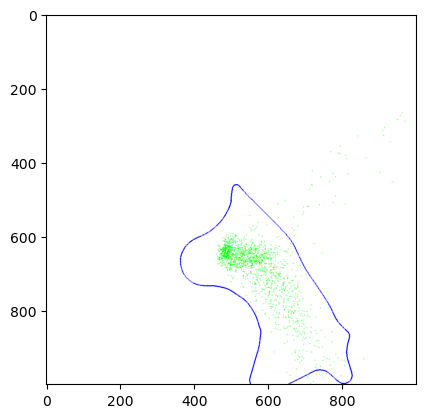

In [26]:
trajectory_image = np.zeros((1000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

for i in range(len(predicted_poses_e)):
    # position is 3d, extract x and y
    predicted_pos = predicted_poses_e[i]["position"][[0, 2]]
    true_pos = true_poses_e[i]["position"][[0, 2]]

    predicted_pos = predicted_pos
    true_pos = true_pos

    predicted_pos = predicted_pos.astype(np.int32)
    true_pos = true_pos.astype(np.int32)

    predicted_pos += 500
    true_pos += 500

    cv2.circle(trajectory_image, tuple(predicted_pos[:2]), 1, (0, 255, 0), 1)
    cv2.circle(trajectory_image, tuple(true_pos[:2]), 1, (0, 0, 255), 1)

plt.imshow(trajectory_image)